## HW2: KNN from scratch

In [104]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
o,z = np.ones(325),np.zeros(325)

In [52]:
np.append(o,z).shape

(650,)

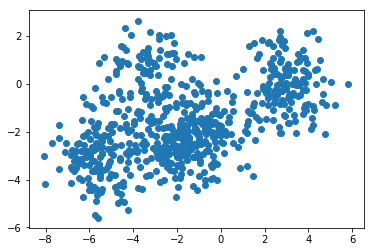

In [217]:
np.random.seed(37)
data = np.vstack(((np.random.randn(150, 2)  + np.array([3, 0])),
               (np.random.randn(100, 2)  + np.array([-3.5, 0.5])),
               (np.random.randn(100, 2) + np.array([-0.5, -2])),
               (np.random.randn(150, 2) + np.array([-2, -2.5])),
               (np.random.randn(150, 2) + np.array([-5.5, -3]))))
#X = np.hstack([data,np.random.randint(0,2,650).reshape(-1,1)])
X = np.hstack([data,np.append(np.ones(325),np.zeros(325)).reshape(-1,1)])
plt.scatter(X[:,0],X[:,1])

train,test = train_test_split(X)
X_tr,Y_tr = train[:,:2],train[:,2]
X_t,Y_t = test[:,:2],test[:,2]

### Pure KNN

In [166]:
class KNN(object):
    """
    KNN for classification 
    
    Argumants:
    ---------
    k -- number of nearest neighbours
    X -- input matrix of shape ()
    n -- number of classes
    method -- str -- can use 'parzen' or 'potentials'. Otherwise, will run simple KNN
    
    """
    def euclidean_dist(self,x,y):
        """
        euclidean distance between points x and y
        """
        #print(x,y)
        if type(x)==np.float64:
            return ((y-x)**2)**0.5
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    
    def split_data(self):
        train_data, test_data = train_test_split(self.X)
        self.X_train, self.Y_train = train_data[:,:2],train_data[:,2]
        self.X_test, self.Y_test = test_data[:,:2],test_data[:,2]
        
        
    def __init__(self,k,X=None,X_train=None,X_test=None,Y_train=None,Y_test=None):
        self.k = k
        if X is None:
            self.X_train,self.X_test = X_train,X_test
            self.Y_train,self.Y_test = Y_train,Y_test
            self.n = len(np.unique(Y_tr))
        else:
            self.X = X
            self.split_data()
            self.n = len(np.unique(X[:,-1]))
        
            
    def get_neighbours(self,point,flag=None):
        """
        Arguments:
        ---------
        point -- array of shape(,), chosen point from test
        Returns:
        ---------
        list of indices of k nearest points
        
        """
        #calculate k closest points from train
        distances = {self.euclidean_dist(self.X_train[i],point) : i for i in range(len(self.X_train)) if (self.X_train[i]!=point).all() }
        distances = OrderedDict(sorted(distances.items()))
        
        if flag=="parzen":
            return distances
        
        #return indices of k closest points
        k_nearest = list(distances.items())[:self.k]
        return [row[1] for row in k_nearest]
        
        
    def vote(self,k_neighbours):
        """
        returns most frequent class among k_neighbours
        """
        return np.argmax(np.bincount(self.Y_train.astype(int)[k_neighbours]))
        
        
    def predict(self):
        """
        returns predictions for test set
        """
        prediction = []
        # for each point in test 
        for point in self.X_test:
            #get indexes of k closest points
            k_neighbours = self.get_neighbours(point)
            #select class based on 'voting' process
            prediction.append(self.vote(k_neighbours))
        self.pred = np.array(prediction)
        return self.pred
    
    def calculate_accuracy(self):
        count = sum(1 for i in range(len(self.pred)) if self.pred[i]==self.Y_test[i])
        return count/len(self.pred)

#### Testing simple KNN

In [167]:
model = KNN(k=10,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
pred = model.predict()
model.calculate_accuracy()

0.8466257668711656

### Потенциалы

### Parzen windows

In [275]:
class Parzen(KNN):
    """
    KNN using Parzen window 
    Arguments:
    ---------
    h -- window width
    """ 
    def __init__(self,h,X=None,X_train=None,Y_train=None,X_test=None,Y_test=None):
        self.h = h
        self.k = len(X_train)
        self.X_train=X_train
        self.Y_train=Y_train
        self.X_test=X_test
        self.Y_test=Y_test
        
        super().__init__(k,X=X,X_train=self.X_train,Y_train=self.Y_train,X_test=self.X_test,Y_test=self.Y_test)

    def select_neighbours(self,point):
        """
        Arguments:
        ---------
        point -- array of shape(,), chosen point from test
        Returns:
        ---------
        all nearest points at distances no more than width of a Parzen window 
        """
        neighbours = super().get_neighbours(point,'parzen')
        indices,distances = list(neighbours.values()), (neighbours.keys())
        
        i = sum(1 if d<=self.h else 0 for d in distances)
            
        return indices[:i]
    
    def modify_h(self,point):
        neighbours = super().get_neighbours(point,'parzen')
        indices,distances = list(neighbours.keys()), list(neighbours.values())
        self.h = self.h*0.33 + distances[0]
        
    def predict(self):
        """
        returns predictions for test set
        """
        prediction = []
        for point in self.X_test:
        #get indexes of k closest points
            neighbours = self.select_neighbours(point)
            #if not neighbours:
                #self.modify_h(point)
                #self.predict()
            prediction.append(super().vote(neighbours)) if neighbours else prediction.append(None)
                
            
        self.pred = np.array(prediction)
        return self.pred

In [281]:
test = Parzen(0.85,None,X_train=X_tr,Y_train=Y_tr,X_test=X_t,Y_test=Y_t)
test.predict()
test.calculate_accuracy()

0.8711656441717791

### Visualisation

In [72]:
def visualize_old(train,test,pred):
    plt.figure(figsize=(20,10))
    
    data = np.concatenate([train,test])
    
    l = len(np.unique(test[:,2]))
    cmap = [x/(l*2) for x in range(2*l)]
    c = np.copy(train[:,2])
    d = np.copy(test[:,2])
    for i in range(l):
        c[c==i]=cmap[i]
        d[d==i]=cmap[l+i]
    cm = np.concatenate([c,d])
    plt.scatter(data[:,0],data[:,1],c= cm ,s=50,marker='o')
    #plt.scatter(test[:,0],test[:,1],c = d,s=200,marker='o')

    
    plt.legend(['train data'],loc=1)
    plt.show()

In [ ]:
def visualise_classes(train,test,pred_labels):
    plt.figure(figsize=(20,10))
    
    #different colors for train classes\predicted test classes
    
    c = len(np.unique(test[:,2]))
    cmap =[x/(2*l) for x in range(2*l)]
    
    
    plt.legend()
    plt.show()

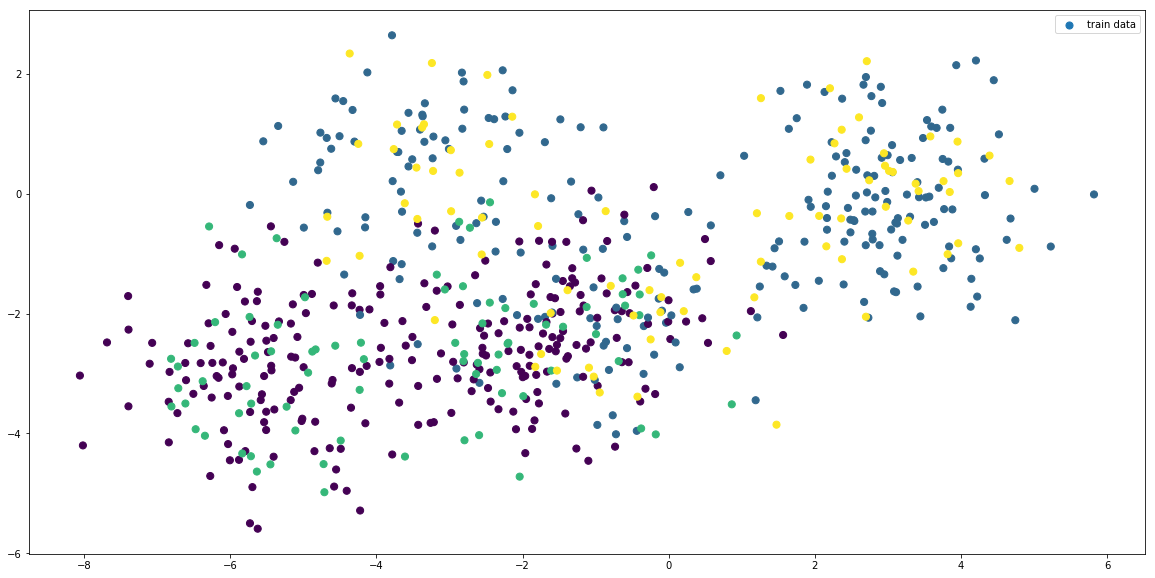

In [73]:
visualize_classes(train,test,pred)